In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import joblib

In [4]:
df=pd.read_csv("insurance.csv")

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
df.duplicated().sum()

1

In [9]:
duplicates=df[df.duplicated(keep=False)]
print(duplicates)

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [10]:
df=df.drop_duplicates()

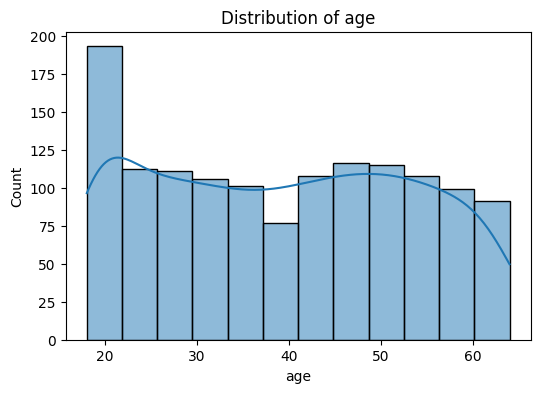

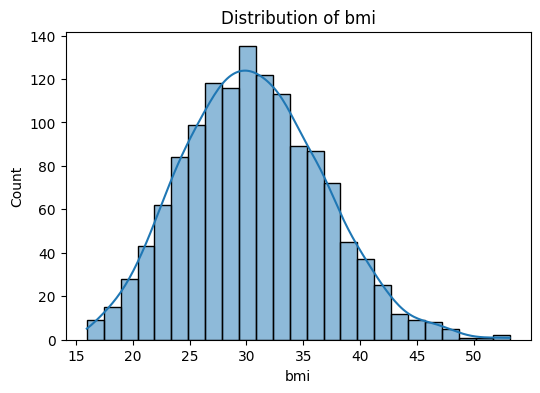

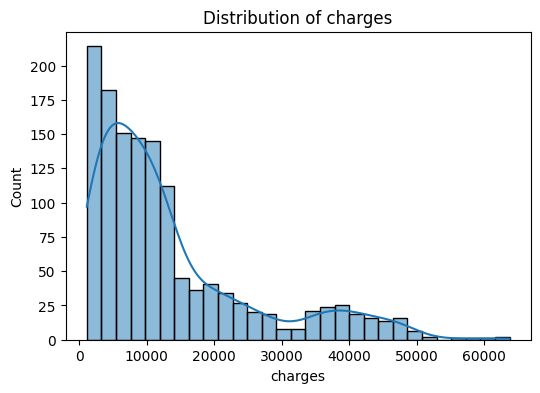

In [11]:
num_cols=['age','bmi','charges']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

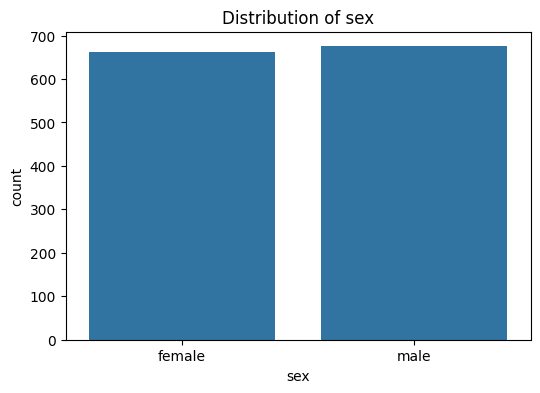

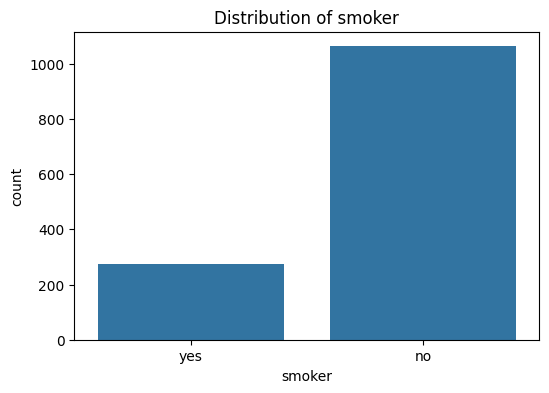

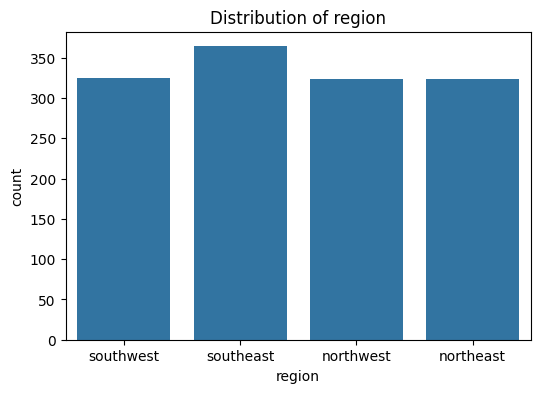

In [12]:
cat_cols=['sex','smoker','region']
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col,data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

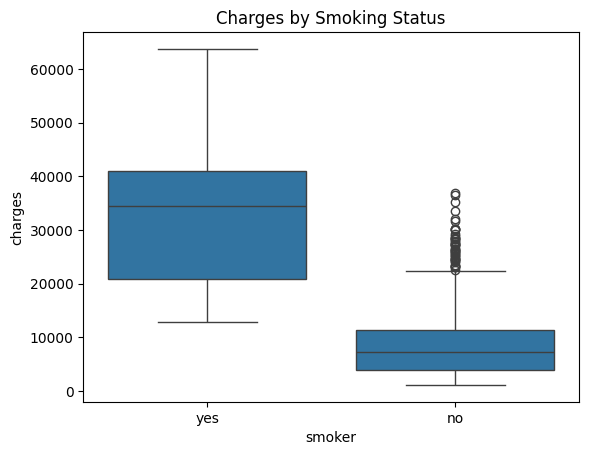

In [13]:
sns.boxplot(data=df,x='smoker',y='charges')
plt.title('Charges by Smoking Status')
plt.show()

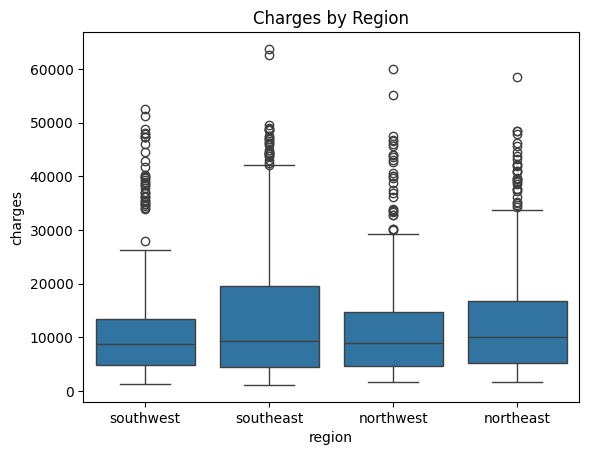

In [14]:
sns.boxplot(data=df, x='region', y='charges')
plt.title("Charges by Region")
plt.show()


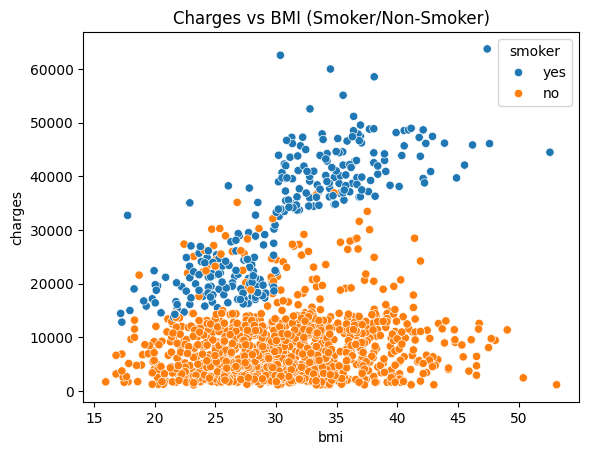

In [15]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')
plt.title("Charges vs BMI (Smoker/Non-Smoker)")
plt.show()


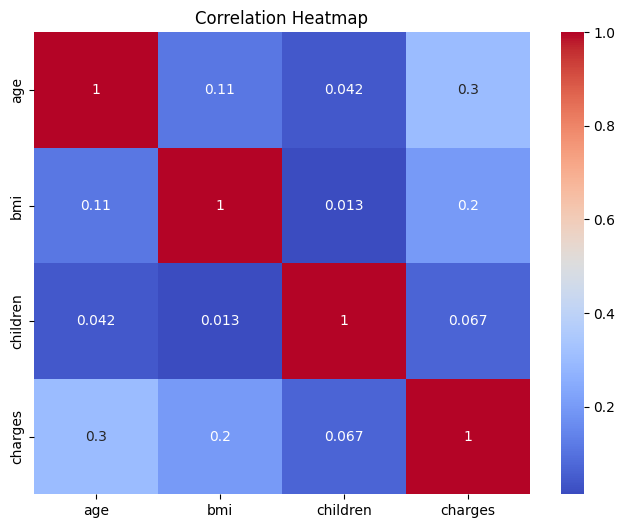

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [17]:
def bmi_group(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_group'] = df['bmi'].apply(bmi_group)


In [18]:
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100],
                         labels=['child', 'young_adult', 'adult', 'senior', 'elder'])

df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region', 'age_group', 'bmi_group'], drop_first=True)


In [19]:
X = df_encoded.drop(['charges'], axis=1)
y = df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
def evaluate_model(y_true,y_pred):
    mae=mean_absolute_error(y_true,y_pred)
    rmse=np.sqrt(mean_squared_error(y_true,y_pred))
    r2=r2_score(y_true,y_pred)

    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

In [22]:
lr=LinearRegression()
lr.fit(X_train_scaled,y_train)
lr_pred=lr.predict(X_test_scaled)
print("Linear Regression Model")
evaluate_model(y_test,lr_pred)

Linear Regression Model
MAE:  4380.2225
RMSE: 6055.1958
R²:   0.8005


In [23]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost Model")
evaluate_model(y_test, y_pred_xgb)

XGBoost Model
MAE:  2903.9122
RMSE: 5063.7942
R²:   0.8605


In [24]:
rf=RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled,y_train)
rf_pred=rf.predict(X_test_scaled)
importances=rf.feature_importances_
print("Random Forest Regressor Model")
evaluate_model(y_test,rf_pred)

Random Forest Regressor Model
MAE:  2694.8918
RMSE: 4712.3904
R²:   0.8792


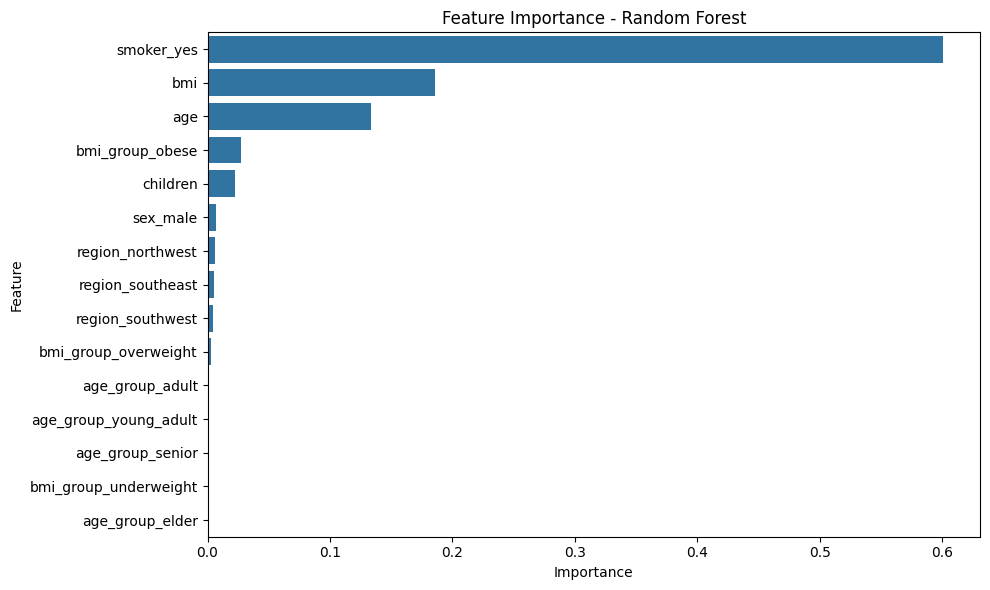

In [25]:
feature_names = X_train.columns
importances = rf.feature_importances_

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [26]:
rf = RandomForestRegressor(random_state=42)

y_pred_cv = cross_val_predict(rf, X_train_scaled, y_train, cv=5)

print("Cross-Validation Results (Untuned Model)")
evaluate_model(y_train,y_pred_cv)

Cross-Validation Results (Untuned Model)
MAE:  2800.4555
RMSE: 4989.1572
R²:   0.8182


In [27]:
rf_model= RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

joblib.dump(rf_model, 'model/rf_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(X.columns.tolist(), 'model/feature_columns.pkl')

['model/feature_columns.pkl']

<!-- "The scatter plot of actual vs predicted charges shows a strong linear relationship along the diagonal, especially for lower and medium-range charges. This indicates that the model is capturing the underlying pattern quite well. However, some higher charge predictions show slight variance, which could be due to complex non-linear effects not fully captured by the model." -->